# Bingo Tutorial 4: Symbolic Regression

## Goal: Given input data and output data, find the functional form of the equation

### Acyclic Graphs

Equations are represented as acyclic graphs in bingo.  The `AcyclicGraphChromosome` encapsulates a list of mathematical commands, performed in a set order, that define an equation.  These are called AGraphs in bingo.

### Explicit Training Data
The way an AGraph's fitness is evaluated is whether or not it models some training data correctly. When both input and outputs are present in the training data, explicit regression is used.  This requires having some valid `ExplicitTrainingData`. `ExplicitTrainingData` requires x (input) and y (output) as numpy arrays.

In [1]:
import numpy as np

from bingo.symbolic_regression import ExplicitTrainingData

x = np.linspace(-10, 10, 30).reshape([-1, 1])
y = x**2 + 3.5*x**3
training_data = ExplicitTrainingData(x, y)

/home/runner/work/bingo/bingo/bingo/symbolic_regression/__init__.py:31: UserWarning: Could not load C++ modules No module named 'bingocpp.build'
  warnings.warn(f"Could not load C++ modules {import_err}")


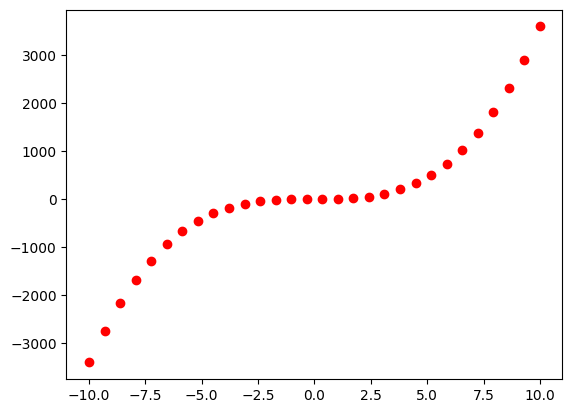

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.plot(training_data.x, training_data.y, 'ro')
plt.show()

### AGraph Component Generator
AGraphs also require a component generator to generate elements of an acylic graph object. It plays a similar role as `get_random_float` in the ZeroMinExample jupyter notebook.

The dimension of the independent variable (x) is needed for the initialization of the component generator.  After initialization, mathematical operators can be added to the generator.  These operators constitute the building blocks from which the AGraphs will be made.

In [3]:
from bingo.symbolic_regression import ComponentGenerator

component_generator = ComponentGenerator(input_x_dimension=x.shape[1])
component_generator.add_operator("+")
component_generator.add_operator("-")
component_generator.add_operator("*")

### AGraph Generator
The AGraph generator will use the component generator to generate `AGraphChromosome` individuals. In addion to the component generator, the desired size of the AGraphs is needed in initialization.  This size corresponds to the number of maximum number of commands possible in the AGraph. In other words, a larger size allows for more complex equations but comes at the cost of longer evaluation times.

In [4]:
from bingo.symbolic_regression import AGraphGenerator

agraph_generator = AGraphGenerator(agraph_size=10, 
                                   component_generator=component_generator)

In [5]:
agraph = agraph_generator()
print("f(X_0) = ", agraph)

f(X_0) =  (X_0)(X_0 - (X_0) + X_0 - (X_0))


Try rerunning the snippet above a few times to see some different equations produced by the genrator.  Note that X_0 represents the first dimension of the independent variable.  Also note that all numerical constants equal 1.0 unless local optimization is performed (more on this later).

### AGraph Variation
Set the the variation amongst the population per generation. 
AGraphCrossover is single-point.  Mutation contains several possible mutation strategies, most of which are single-point.  See documentation for more in depth description of mutation types and tailoring the mutation function. Both the crossover and mutation require the component generator.

In [6]:
from bingo.symbolic_regression import AGraphCrossover
from bingo.symbolic_regression import AGraphMutation

crossover = AGraphCrossover()
mutation = AGraphMutation(component_generator)

### Evaluation: Explicit Regression

The type of regression that will be used is `ExplicitRegression` since the training data has both input and output data to train against. `ExplicitRegression` extends `FitnessFunction`; hence, may be passed to `LocalOptFitnessFunction` object as an argument. This is then passed to an `Evaluation` object which will run `ExplicitRegression` on all `AGraph` individuals.

The `LocalOptFitnessFunction` is responsible for finding the best numerical constants for the given explicit regression.  The numerical constants are represented by "?" before local optimization has been performed (as you may have seen in the AGraph Generator section). 

In [7]:
from bingo.symbolic_regression import ExplicitRegression
from bingo.local_optimizers.scipy_optimizer import ScipyOptimizer
from bingo.local_optimizers.local_opt_fitness import LocalOptFitnessFunction
from bingo.evaluation.evaluation import Evaluation

fitness = ExplicitRegression(training_data=training_data)
optimizer = ScipyOptimizer(fitness, method='lm')
local_opt_fitness = LocalOptFitnessFunction(fitness, optimizer)
evaluator = Evaluation(local_opt_fitness)

In [8]:
np.random.seed(16)
agraph = agraph_generator()
print("Before local optimization: f(X_0) = ", agraph)
print("                          fitness = ", fitness(agraph))
_ = local_opt_fitness(agraph)
print("After local optimization:  f(X_0) = ", agraph)
print("                          fitness = ", fitness(agraph))

Before local optimization: f(X_0) =  ((1.0)(1.0))(X_0) + 1.0
                          fitness =  961.4215397651949
After local optimization:  f(X_0) =  ((0.12642146513365998)(1773.033577854415))(X_0) + 35.63218390804609
                          fitness =  500.369376865586


The AGraphs can be easily evaluated at a given x.

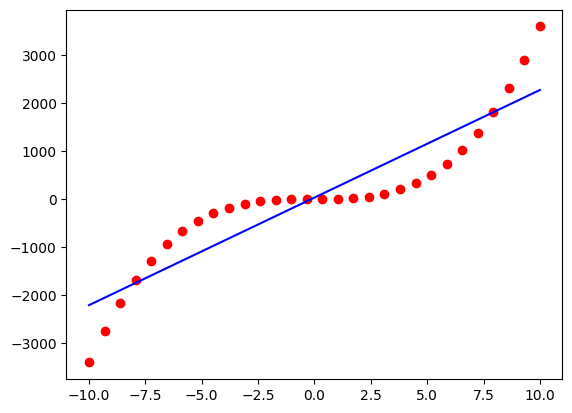

In [9]:
agraph_y = agraph.evaluate_equation_at(training_data.x)

plt.plot(training_data.x, training_data.y, 'ro')
plt.plot(training_data.x, agraph_y, 'b-')
plt.show()

### Age Fitness Evolutionary Algorithm

The evoluaionary algorithm used in this example is `AgeFitnessEA`. This by default uses the `AgeFitnessSelection`. It also requires use of the `AGraphGenerator` in order to seed a random individuals.  The Age Fitness EA is used to combat premature convergence that can be seen in symbolic regression.

In [10]:
from bingo.evolutionary_algorithms.age_fitness import AgeFitnessEA

POPULATION_SIZE = 32
MUTATION_PROBABILITY = 0.4
CROSSOVER_PROBABILITY = 0.4

ea = AgeFitnessEA(evaluator, agraph_generator, crossover, mutation, 
                  CROSSOVER_PROBABILITY, MUTATION_PROBABILITY, POPULATION_SIZE)

### Pareto Front

A `ParetoFront` hall of fame object is useful in symbolic regression for tracking the best individuals, where fitness and equation complexity are both taken into consideration. The secondary key must be supplied to the `ParetoFront` object. The primary key can optionally be supplied instead of the default use of fitness. 

In [11]:
from bingo.stats.pareto_front import ParetoFront

def agraph_similarity(ag_1, ag_2):
    """a similarity metric between agraphs"""
    return ag_1.fitness == ag_2.fitness and ag_1.get_complexity() == ag_2.get_complexity()

pareto_front = ParetoFront(secondary_key=lambda ag: ag.get_complexity(),
                           similarity_function=agraph_similarity) 

### Evolution on an island
Once an `Island` is set up, evolution occurs in the same way as described in earlier examples.

In [12]:
from bingo.evolutionary_optimizers.island import Island
np.random.seed(5)

island = Island(ea, agraph_generator, POPULATION_SIZE, hall_of_fame=pareto_front)
print("Best individual\n f(X_0) =", island.get_best_individual())

Best individual
 f(X_0) = (224.14982164090543 + 224.14982164090543 - (224.14982164090543))(X_0)


Run until convergence. Print the best result. We store each best individual in a list and use this to observe how the best solution evolves over time.

In [13]:
ERROR_TOLERANCE = 1e-6

best_indv_values = []
best_indv_values.append(island.get_best_individual())
best_indv_gen = []
best_indv_gen.append(island.generational_age)

while island.get_best_fitness() > ERROR_TOLERANCE:
    island.evolve(1)
    best_indv = island.get_best_individual()
    if best_indv.fitness < best_indv_values[-1].fitness:
        best_indv_values.append(best_indv)
        best_indv_gen.append(island.generational_age)

print("Generation: ", island.generational_age)
print("Success!")
print("Best individual\n f(X_0) =", island.get_best_individual())

Generation:  223
Success!
Best individual
 f(X_0) = (((X_0)(-10594.087114753529 - (-10597.587114753529)))(X_0) + X_0)(X_0)


We can look at the pareto then look at the Pareto front to see the tradeoff between fitness and complexity

In [14]:
print(" FITNESS   COMPLEXITY    EQUATION")
for member in pareto_front:
    print("%.3e     " % member.fitness, member.get_complexity(),
          "     f(X_0) =", member)

 FITNESS   COMPLEXITY    EQUATION
6.068e-14      9      f(X_0) = (((X_0)(-10594.087114753529 - (-10597.587114753529)))(X_0) + X_0)(X_0)
3.166e+00      8      f(X_0) = (X_0)(X_0) + ((X_0)((X_0 + X_0)(X_0 + X_0)))(0.8721342056188445)
1.256e+01      7      f(X_0) = (((X_0)(3.4545115160181012))(X_0) + X_0)(X_0)
3.563e+01      6      f(X_0) = (((X_0 + X_0)(0.9354143466934853))((X_0 + X_0)(0.9354143466934853)))(X_0)
1.381e+02      5      f(X_0) = (X_0)(X_0 + (X_0 + X_0)(X_0 + X_0))
1.381e+02      4      f(X_0) = ((X_0 + X_0)(X_0 + X_0))(X_0)
5.025e+02      3      f(X_0) = (X_0)(224.1498216409036)
9.562e+02      2      f(X_0) = X_0 + X_0
9.614e+02      1      f(X_0) = X_0


### Animation of evolution

In [15]:
def animate_data(list_of_best_indv, list_of_best_gens, training_data):

    fig, ax = plt.subplots()
    
    num_frames = len(list_of_best_indv)
    
    x = training_data.x
    y_actually = training_data.y
    y = list_of_best_indv
    g = list_of_best_gens
    plt.plot(training_data.x, training_data.y, 'ro')
    points, = ax.plot(x, y[0].evaluate_equation_at(x), 'b')
    points.set_label('Generation :' + str(g[0]))
    legend = ax.legend(loc='upper right', shadow=True)


    def animate(i):
        for artist in ax.collections:
            artist.remove()
        points.set_ydata(y[i].evaluate_equation_at(x))  # update the data
        points.set_label('Generation :' + str(g[i]))
        legend = ax.legend(loc='upper right')
        return points, legend


    # Init only required for blitting to give a clean slate.
    def init():
        points.set_ydata(np.ma.array(x, mask=True))
        return points, points

    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.title("Best Individual in Island", fontsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)
    plt.close()

    return animation.FuncAnimation(fig, animate, num_frames, init_func=init,
                                interval=250, blit=True)

In [16]:
from IPython.display import HTML
anim2 = animate_data(best_indv_values, best_indv_gen, training_data)
HTML(anim2.to_jshtml())